In [1]:
import torch
import hydra
from omegaconf import OmegaConf
from pathlib import Path
from einops import rearrange
from lightning_modules.models.registration_module import ICL_Reg
from corrfield.corrfield import corrfield
from monai.networks.blocks import Warp
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Any, Dict, List, Union
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from ipywidgets import widgets
from IPython.display import display
from perlin_noise import PerlinNoise
%matplotlib inline


/gpfs/helios/home/tsiporen/.conda/envs/CTREG/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/gpfs/space/home/tsiporen/.conda/envs/CTREG/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Generate a DDF from a reference image and a moving image | Consider only a Lung part based on a moving mask | Used for a validation process
def generate_cutom_ddf(fix_img: torch.Tensor, fix_mask: torch.Tensor, mov_img: torch.Tensor, mov_mask: torch.Tensor ) -> torch.Tensor:
    ddf, _, _ = corrfield(fix_img, fix_mask, mov_img, 2.5, 150, 5, 1, 3, 0, 1, 1.4, 0.8, True, [16, 8], [6, 3], [2, 1], [3, 2], ['n', 'n'])
    ddf_masked = ddf.detach().cpu().clone()
    ddf_masked[~mov_mask.squeeze(1).to(torch.bool)] = 0

    return ddf_masked

In [3]:
# Helper func to crop / fill rest with zeros when warping a tensor
def adjust_ddf(ddf_masked: torch.Tensor, mov_mask: torch.Tensor) -> torch.Tensor:
    batch_size = mov_mask.shape[0]
    ddf_masked_adjusted = ddf_masked.clone().repeat(batch_size, 1, 1, 1, 1)
    ddf_masked_adjusted[~mov_mask.squeeze(1).to(torch.bool)] = 0
    return ddf_masked_adjusted

In [4]:
cfg = OmegaConf.load("/gpfs/space/projects/BetterMedicine/illia/bm-ai-pipelines/common/ocs/lightning_pipeline/lightning_logs/registration_NLST_ICON/version_54/hparams.yaml")  # Update path if necessary
vessels_ckpt = '/gpfs/space/projects/BetterMedicine/illia/bm-ai-pipelines/common/ocs/lightning_pipeline/lightning_logs/registration_NLST_ICON/version_54/checkpoints/epoch=374-val_tre=3.416-val_dice=0.172.ckpt'
# mask_ckpt = '/gpfs/space/projects/BetterMedicine/illia/bm-ai-pipelines/common/ocs/lightning_pipeline/lightning_logs/registration_NLST_ICON/version_92/checkpoints/epoch=104-val_tre=3.237-val_dice=0.846.ckpt'

In [5]:
cfg.datamodule.config.dataloaders.val_dataloader.batch_size = 1
cfg.datamodule.config.dataloaders.train_dataloader.batch_size = 1


In [6]:
model = ICL_Reg(cfg)
model.load_pretrain(ckpt_path=vessels_ckpt)
model.cuda()
model.eval()

/gpfs/helios/home/tsiporen/.conda/envs/CTREG/lib/python3.9/site-packages/monai/networks/blocks/warp.py:72: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")
/gpfs/space/projects/BetterMedicine/illia/bm-ai-pipelines/common/ocs/lightning_pipeline/lightning_modules/models/registration_module.py:239: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by

ICL_Reg(
  (net): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        (submo

In [7]:
warper = Warp()

In [8]:
datamodule = hydra.utils.instantiate(cfg.datamodule)
datamodule.setup(stage="fit")


Caching training data...
Finished caching data in 0.00 seconds


In [9]:
val_loader = datamodule.val_dataloader()

/gpfs/helios/home/tsiporen/.conda/envs/CTREG/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
train_loader = datamodule.train_dataloader()

In [11]:
data_iter = iter(val_loader)
sample_batch = next(data_iter)
ddf_masked = generate_cutom_ddf(sample_batch['fixed_image'], sample_batch['fixed_label'], sample_batch['moving_image'], sample_batch['moving_label'])

Compute fixed MIND features ... 

/gpfs/helios/home/tsiporen/.conda/envs/CTREG/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


finished (3.50 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (2.77 s).

    1118 fixed keypoints extracted (5.79 s).
    Compute forward marginals ... 

/gpfs/space/projects/BetterMedicine/illia/corrfield/corrfield/graphs.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edges = torch.tensor([bfo[1][bfo[0]][1:], bfo[0][1:]], dtype=torch.long).t().view(1, -1, 2)


finished (33.78 s).
    Compute symmetric backward marginals ... finished (28.04 s).
    Dense thin plate spline interpolation ... finished (2.36 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (2.76 s).

    2158 fixed keypoints extracted (2.46 s).
    Compute forward marginals ... finished (8.71 s).
    Compute symmetric backward marginals ... finished (8.74 s).
    Dense thin plate spline interpolation ... finished (3.67 s).



In [12]:
def vis_ddf(ddf: torch.Tensor, image: torch.Tensor, slice_idx: int = 128, sample_factor: int = 10, alpha: float = 0.5) -> None:
    plt.close()
    ct_slice = image[0][0][:, :, slice_idx].detach().cpu().numpy()
    ddf_slice = ddf[0][:, :, slice_idx].detach().cpu().numpy()

    X, Y = np.meshgrid(np.arange(0, ct_slice.shape[1]), np.arange(0, ct_slice.shape[0]))
    U, V = ddf_slice[:, :, 0], ddf_slice[:, :, 1]

    X_sub = X[::sample_factor, ::sample_factor]
    Y_sub = Y[::sample_factor, ::sample_factor]

    U_sub = U[::sample_factor, ::sample_factor]
    V_sub = V[::sample_factor, ::sample_factor]

    magnitude = np.sqrt(U**2 + V**2)
    magnitude_sub = np.sqrt(U_sub**2 + V_sub**2)

    cmap = plt.get_cmap('viridis')
    norm = Normalize(vmin=0, vmax=np.percentile(magnitude, 95))
    cmap.set_bad(color='black')

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(ct_slice, cmap='gray')

    ax.quiver(X_sub, Y_sub, U_sub, V_sub, magnitude_sub, cmap=cmap, scale=1, scale_units='xy', angles='xy', alpha=alpha)
    
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(magnitude)
    fig.colorbar(sm, ax=ax)

    ax.set_title(f'CT slice at {slice_idx} idx')
    plt.show()

In [13]:
def scroll_image(image: torch.Tensor, ddf: torch.Tensor, sample_factor: int = 5, alpha: float = 0.9):
    slice_slider = widgets.IntSlider(min=0, max=(image[0][0].shape[2]), step=1, description='Slice:', value=(image[0][0].shape[2] // 2), continuous_update=False)

    def update_slice(slice_idx):
        vis_ddf(ddf, image, slice_idx=slice_idx, sample_factor=sample_factor, alpha=alpha)

    int_plot = widgets.interactive(update_slice, slice_idx=slice_slider)
    display(int_plot)
                 

In [14]:
scroll_image(sample_batch['moving_image'], ddf_masked, sample_factor=5, alpha=0.9)

interactive(children=(IntSlider(value=112, continuous_update=False, description='Slice:', max=224), Output()),…

In [15]:
sample_dl_batch = {}
for items in sample_batch:
    sample_dl_batch[items] = sample_batch[items].float().cuda()

ddf_dl = model(sample_dl_batch)

/gpfs/helios/home/tsiporen/.conda/envs/CTREG/lib/python3.9/site-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [16]:
ddf_dl_masked = adjust_ddf(rearrange(ddf_dl[0], "B C H W D -> B H W D C"), sample_batch['moving_label'])
ddf_dl_masked.shape

torch.Size([1, 224, 192, 224, 3])

In [17]:
scroll_image(sample_batch['moving_image'], ddf_dl_masked, sample_factor=5, alpha=0.9)

interactive(children=(IntSlider(value=112, continuous_update=False, description='Slice:', max=224), Output()),…

In [18]:
print(f'Value of DL at [175, 75, 128] {ddf_dl_masked[0, 175, 75, 128]}')
print(f'Value of CF at [175, 75, 128] {ddf_masked[0, 175, 75, 128]}')

Value of DL at [175, 75, 128] tensor([1.7244, 2.3503, 4.9966], device='cuda:0', grad_fn=<AliasBackward0>)
Value of CF at [175, 75, 128] tensor([-1.9012, -2.4565, -5.7705])


In [19]:
def compute_r2(y_pred: torch.Tensor, y_true: torch.Tensor, y_true_mean: torch.Tensor = 0) -> float:
    r2 = 1 - (torch.sum((y_true - y_pred).pow(2)) / torch.sum((y_true - y_true_mean).pow(2)))
    return r2.item()

In [20]:
mses = []
mses_corr = []
r_2 = []
r_2_corr = []
mean_0 = []
batch_res = []

for i, batch in enumerate(val_loader):
    if i == 0:
        continue
    custom_ddf = None
    for key in batch:
        ddf_masked_adjusted = adjust_ddf(-ddf_dl_masked, batch['moving_label'])
        ddf_masked_adjusted = rearrange(ddf_masked_adjusted, 'B H W D C -> B C H W D')

        # Actually here we should warp(M) and ontain (F_distorted). So this is worng:
        #  
            # batch['moving_label'] = (warper(batch['moving_label'].cuda(), ddf_masked_adjusted.cuda()) > 0).float()
            # batch['moving_image'] = warper(batch['moving_image'].cuda(), ddf_masked_adjusted.cuda())
        #
        # The right way to do it:
        #
        batch['fixed_label'] = (warper(batch['moving_label'].cuda(), ddf_masked_adjusted.cuda()) > 0).float()
        batch['fixed_image'] = warper(batch['moving_image'].cuda(), ddf_masked_adjusted.cuda())
        #

        custom_ddf = ddf_masked_adjusted

        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].cuda()

    ddf_corrfield, _, _ = corrfield(batch['fixed_image'], batch['fixed_label'], batch['moving_image'], 2.5, 150, 5, 1, 3, 0, 1, 1.4, 0.8, True, [16, 8], [6, 3], [2, 1], [3, 2], ['n', 'n'])
    ddf_corrfield = ddf_corrfield.detach().cpu()
    ddf_corrfield[~batch['moving_label'].squeeze(1).to(torch.bool)] = 0
    ddf_corrfield = rearrange(ddf_corrfield, 'B H W D C -> B C H W D')

    ddf_image, _, _, _, _ = model(batch)
    ddf_image = ddf_image.detach().cpu()
    ddf_image = -ddf_image
    ddf_image[~batch['moving_label'].to(torch.bool).expand_as(ddf_image)] = 0

    ddf_mse = torch.mean((custom_ddf - ddf_image).pow(2)).item()
    ddf_mse_corrfield = torch.mean((custom_ddf - ddf_corrfield).pow(2)).item()

    print(torch.mean((custom_ddf - 0).pow(2)))

    if torch.var(custom_ddf) == 0:
        print(f"Warning: Batch #{i} has zero variance in custom_ddf, R^2 is undefined.")

    if torch.all(custom_ddf == 0):
        print(f"Warning: Batch #{i} custom_ddf is entirely zero.")

    ddf_r2 = compute_r2(ddf_image, custom_ddf)
    ddf_r2_corrfield = compute_r2(ddf_corrfield, custom_ddf)

    mses.append(ddf_mse)
    mses_corr.append(ddf_mse_corrfield)
    r_2.append(ddf_r2)
    r_2_corr.append(ddf_r2_corrfield)
    mean_0.append(torch.mean((custom_ddf - 0).pow(2)).item())

    batch_res_str = f"Batch #{i} | MSE for DL: {ddf_mse} | MSE for CorrField: {ddf_mse_corrfield} | R^2 for DL: {ddf_r2} | R^2 for CorrField: {ddf_r2_corrfield}"
    batch_res.append(batch_res_str)

for res in batch_res:
    print(res)

print('\n')
print(f"Average MSE for DL is {sum(mses) / len(mses)}")
print(f"Average MSE for CorrField is {sum(mses_corr) / len(mses_corr)}")

print(f"Average R^2 for DL is {sum(r_2) / len(r_2)}")
print(f"Average R^2 for CorrField is {sum(r_2_corr) / len(r_2_corr)}")


# print(f"Average MSE for DL is {sum(mses) / len(mses)}")
# print(f"Average MSE for CorrField is {sum(mses_corr) / len(mses_corr)}")
# print(f"Average R^2 for DL is {sum(r_2) / len(r_2)}")
# print(f"Average R^2 for CorrField is {sum(r_2_corr) / len(r_2_corr)}")

Compute fixed MIND features ... finished (0.84 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).

    1119 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... 

: 

/tmp/ipykernel_2838520/1494594079.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mses, mses_corr], labels=["DL", "CorrField"])


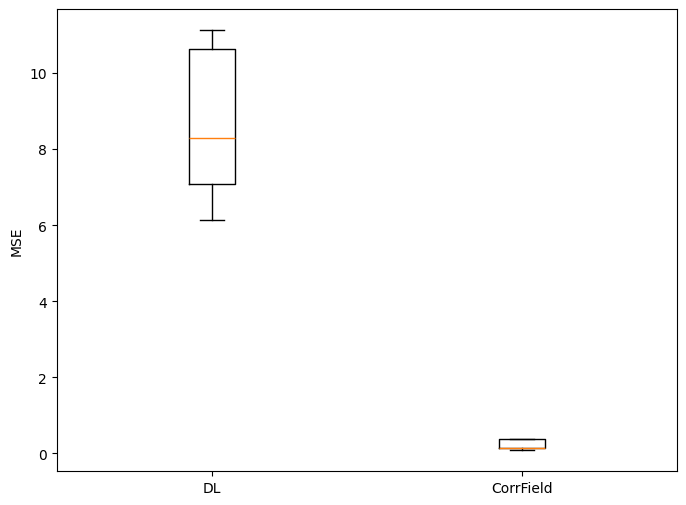

In [24]:
fig, ax = plt.subplots(1, figsize=(8, 6))
plt.boxplot([mses, mses_corr], labels=["DL", "CorrField"])
plt.ylabel("MSE")

plt.show()

# Same thing but kets invert the DDF of DL

In [70]:
mses = []
mses_corr = []
r_2 = []
r_2_corr = []
mean_0 = []
batch_res = []

for i, batch in enumerate(val_loader):
    if i == 0:
        continue
    custom_ddf = None
    for key in batch:
        ddf_masked_adjusted = adjust_ddf(ddf_masked, batch['moving_label'])
        ddf_masked_adjusted = rearrange(ddf_masked_adjusted, 'B H W D C -> B C H W D')

        # Actually here we should warp(M) and ontain (F_distorted). So this is worng:
        #  
            # batch['moving_label'] = (warper(batch['moving_label'].cuda(), ddf_masked_adjusted.cuda()) > 0).float()
            # batch['moving_image'] = warper(batch['moving_image'].cuda(), ddf_masked_adjusted.cuda())
        #
        # The right way to do it:
        #
        batch['fixed_label'] = (warper(batch['moving_label'].cuda(), ddf_masked_adjusted.cuda()) > 0).float()
        batch['fixed_image'] = warper(batch['moving_image'].cuda(), ddf_masked_adjusted.cuda())
        #

        custom_ddf = ddf_masked_adjusted

        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].cuda()

    ddf_corrfield, _, _ = corrfield(batch['fixed_image'], batch['fixed_label'], batch['moving_image'], 2.5, 150, 5, 1, 3, 0, 1, 1.4, 0.8, True, [16, 8], [6, 3], [2, 1], [3, 2], ['n', 'n'])
    ddf_corrfield = ddf_corrfield.detach().cpu()
    ddf_corrfield[~batch['moving_label'].squeeze(1).to(torch.bool)] = 0
    ddf_corrfield = rearrange(ddf_corrfield, 'B H W D C -> B C H W D')

    ddf_image, _, _, _, _ = model(batch)
    ddf_image = ddf_image.detach().cpu()
    ddf_image = -ddf_image
    ddf_image[~batch['moving_label'].to(torch.bool).expand_as(ddf_image)] = 0

    ddf_mse = torch.mean((custom_ddf - ddf_image).pow(2)).item()
    ddf_mse_corrfield = torch.mean((custom_ddf - ddf_corrfield).pow(2)).item()

    print(torch.mean((custom_ddf - 0).pow(2)))

    if torch.var(custom_ddf) == 0:
        print(f"Warning: Batch #{i} has zero variance in custom_ddf, R^2 is undefined.")

    if torch.all(custom_ddf == 0):
        print(f"Warning: Batch #{i} custom_ddf is entirely zero.")

    ddf_r2 = compute_r2(ddf_image, custom_ddf)
    ddf_r2_corrfield = compute_r2(ddf_corrfield, custom_ddf)

    mses.append(ddf_mse)
    mses_corr.append(ddf_mse_corrfield)
    r_2.append(ddf_r2)
    r_2_corr.append(ddf_r2_corrfield)
    mean_0.append(torch.mean((custom_ddf - 0).pow(2)).item())

    batch_res_str = f"Batch #{i} | MSE for DL: {ddf_mse} | MSE for CorrField: {ddf_mse_corrfield} | R^2 for DL: {ddf_r2} | R^2 for CorrField: {ddf_r2_corrfield}"
    batch_res.append(batch_res_str)

for res in batch_res:
    print(res)

print('\n')
print(f"Average MSE for DL is {sum(mses) / len(mses)}")
print(f"Average MSE for CorrField is {sum(mses_corr) / len(mses_corr)}")

print(f"Average R^2 for DL is {sum(r_2) / len(r_2)}")
print(f"Average R^2 for CorrField is {sum(r_2_corr) / len(r_2_corr)}")

Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).

    1141 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.79 s).
    Compute symmetric backward marginals ... finished (0.79 s).
    Dense thin plate spline interpolation ... finished (0.13 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).

    2185 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.96 s).
    Compute symmetric backward marginals ... finished (0.87 s).
    Dense thin plate spline interpolation ... finished (0.14 s).

tensor(2.7946)
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     pat

/tmp/ipykernel_3841185/1494594079.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mses, mses_corr], labels=["DL", "CorrField"])


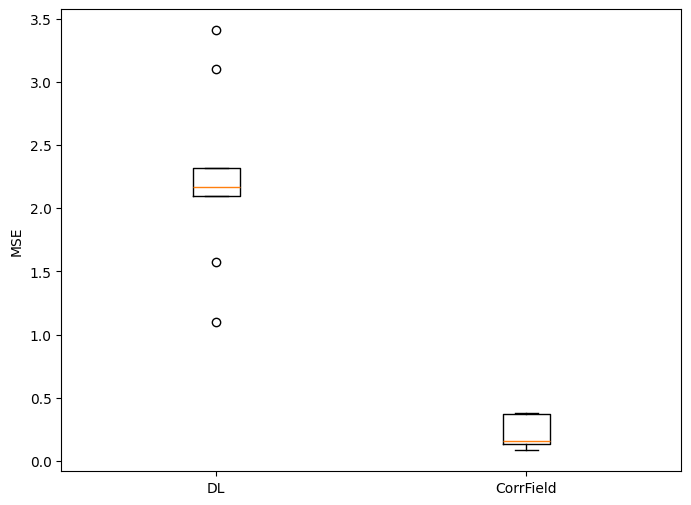

In [71]:
fig, ax = plt.subplots(1, figsize=(8, 6))
plt.boxplot([mses, mses_corr], labels=["DL", "CorrField"])
plt.ylabel("MSE")

plt.show()

/tmp/ipykernel_3841185/3038838700.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mses_no_outliers, mses_corr], labels=["DL", "CorrField"])


{'whiskers': [<matplotlib.lines.Line2D at 0x1492781664c0>,
 'caps': [<matplotlib.lines.Line2D at 0x149278166df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14924d267df0>,
 'medians': [<matplotlib.lines.Line2D at 0x1492780a2ee0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1492780a2550>,
 'means': []}

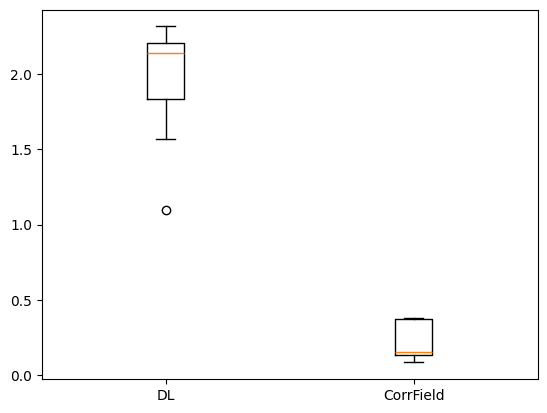

In [72]:
# remove outliers and recalculating the plotbox
mses_no_outliers = [mse for mse in mses if mse < 2.8]
plt.boxplot([mses_no_outliers, mses_corr], labels=["DL", "CorrField"])


# Enhance the DDF generation

In [63]:
def gen_ddfs(val_loader: torch.utils.data.DataLoader,
             samples: int           = 4,
             intensity: float       = 0.5,
             noise_std: float       = 0.01,
             smooth_sigma: float    = 2.5,
             num_generated: int     = 50,
             seed: float            = None) -> Any:
    
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    ddfs = []
    for i, batch in enumerate(val_loader):        
        if i == samples:
            break

        for key in batch:
            batch[key] = batch[key].cuda()

        ddf, _, _ = corrfield(batch['fixed_image'], batch['fixed_label'], batch['moving_image'], 2.5, 150, 5, 1, 3, 0, 1, 1.4, 0.8, True, [16, 8], [6, 3], [2, 1], [3, 2], ['n', 'n'])
        ddf = ddf.detach().cpu()

        noise = torch.randn_like(ddf) * noise_std
        noise = noise.cpu().numpy()

        for i in range(3):
            noise[..., i] = gaussian_filter(noise[..., i], sigma=smooth_sigma)

        noise = torch.from_numpy(noise)
        ddf += noise

        ddf[~batch['moving_label'].squeeze(1).to(torch.bool)] = 0

        ddfs.append(ddf)

    permuted_ddfs = []
    for i in range(num_generated):
        idxs = np.random.choice(len(ddfs), size=2, replace=False)
        selected_ddfs = [ddfs[idx] for idx in idxs]

        weights = np.random.rand(len(selected_ddfs))
        weights /= np.sum(weights)

        permuted_ddf = sum(w * ddf for w, ddf in zip(weights, selected_ddfs))
        permuted_ddfs.append(permuted_ddf)


    return permuted_ddfs


In [54]:
train_iter = iter(train_loader)
train_batch = next(train_iter)

train_ddf_sample, _, _ = corrfield(train_batch['fixed_image'], train_batch['fixed_label'], train_batch['moving_image'], 2.5, 150, 5, 1, 3, 0, 1, 1.4, 0.8, True, [16, 8], [6, 3], [2, 1], [3, 2], ['n', 'n'])

scroll_image(train_batch['moving_image'], train_ddf_sample, sample_factor=5, alpha=0.9)

Compute fixed MIND features ... finished (14.94 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (9.02 s).

    15 fixed keypoints extracted (9.09 s).
    Compute forward marginals ... finished (1.43 s).
    Compute symmetric backward marginals ... finished (1.43 s).
    Dense thin plate spline interpolation ... finished (0.67 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (8.92 s).

    29 fixed keypoints extracted (6.10 s).
    Compute forward marginals ... finished (0.94 s).
    Compute symmetric backward marginals ... finished (0.93 s).
    Dense thin plate spline interpolation ... finished (0.86 s).



interactive(children=(IntSlider(value=112, continuous_update=False, description='Slice:', max=224), Output()),…

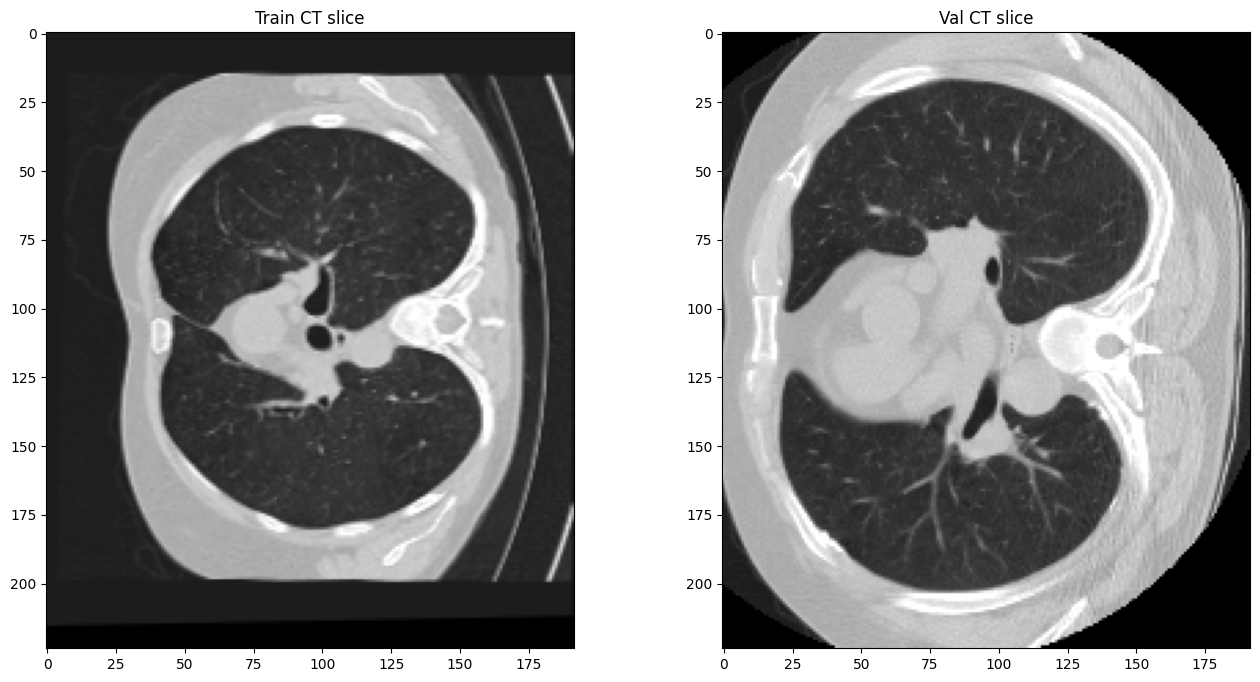

In [69]:
train_sample_ct = next(train_iter)['moving_image']
val_sample_ct = sample_batch['moving_image'] 

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(train_sample_ct[0][0][:, :, 128].detach().cpu().numpy(), cmap='gray')
ax[0].set_title("Train CT slice")
ax[1].imshow(val_sample_ct[0][0][:, :, 128].detach().cpu().numpy(), cmap='gray')
ax[1].set_title("Val CT slice")
plt.show()

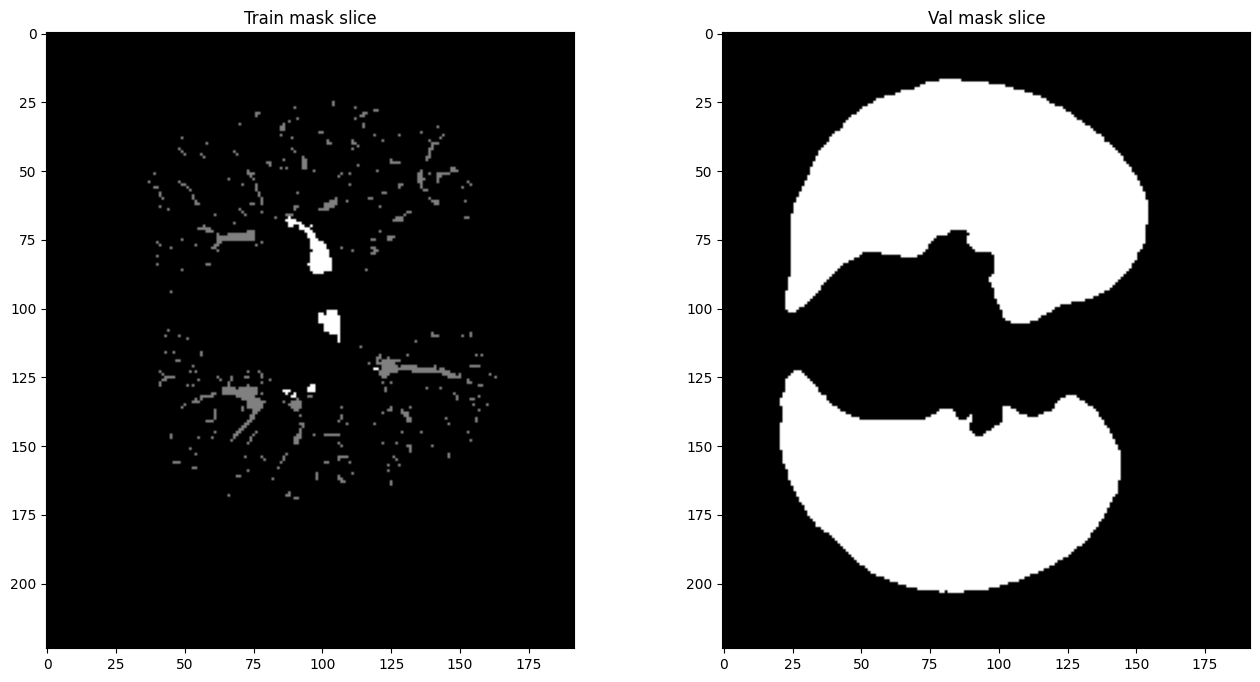

In [70]:
mask_train = next(train_iter)['moving_label']
mask_val = sample_batch['moving_label']

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mask_train[0][0][:, :, 128].detach().cpu().numpy(), cmap='gray')
ax[0].set_title("Train mask slice")
ax[1].imshow(mask_val[0][0][:, :, 128].detach().cpu().numpy(), cmap='gray')
ax[1].set_title("Val mask slice")
plt.show()

In [65]:
ddfs_custom = gen_ddfs(train_loader, samples=2, intensity=0.5, noise_std=0.01, smooth_sigma=2.5, num_generated=5, seed=42)

Compute fixed MIND features ... finished (0.07 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.07 s).

    11 fixed keypoints extracted (0.08 s).
    Compute forward marginals ... finished (0.24 s).
    Compute symmetric backward marginals ... finished (0.13 s).
    Dense thin plate spline interpolation ... finished (0.76 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.06 s).

    15 fixed keypoints extracted (0.08 s).
    Compute forward marginals ... finished (0.08 s).
    Compute symmetric backward marginals ... finished (0.12 s).
    Dense thin plate spline interpolation ... finished (0.85 s).

Compute fixed MIND features ... finished (0.05 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
      

In [75]:
scroll_image(sample_batch['moving_image'], ddfs_custom[0], sample_factor=5, alpha=0.9)

interactive(children=(IntSlider(value=112, continuous_update=False, description='Slice:', max=224), Output()),…

In [66]:
print(f'Generated {len(ddfs_custom)} custom DDFs')
print(f'Shape of each DDF: {ddfs_custom[0].shape}')
print(f'Dtype of each DDF: {ddfs_custom[0].dtype}')

Generated 5 custom DDFs
Shape of each DDF: torch.Size([1, 224, 192, 224, 3])
Dtype of each DDF: torch.float32


In [67]:
y_true_mean = torch.mean(torch.stack(ddfs_custom), dim=0)
y_true_mean = rearrange(y_true_mean, 'B H W D C -> B C H W D')

In [68]:
# assume that the mean of GT values are ~0 (no displacments)
def compute_r2(y_pred: torch.Tensor, y_true: torch.Tensor, y_true_mean: torch.Tensor = y_true_mean) -> float:
    r2 = 1 - (torch.sum((y_true - y_pred).pow(2)) / torch.sum((y_true - y_true_mean).pow(2)))
    return r2.item()

In [69]:
mses_dl = []
mses_corrfield = []
r2_dl = []
r2_corrfield = []
for custom_ddf in ddfs_custom:
    for i, batch in enumerate(val_loader):
        custom_adjusted_ddf = None
        for key in batch:
            ddf_masked_adjusted = adjust_ddf(custom_ddf, batch['moving_label'])
            ddf_masked_adjusted = rearrange(ddf_masked_adjusted, 'B H W D C -> B C H W D')
            custom_adjusted_ddf = ddf_masked_adjusted

            batch['moving_label'] = (warper(batch['moving_label'].cuda(), ddf_masked_adjusted.cuda()) > 0).float()
            batch['moving_image'] = warper(batch['moving_image'].cuda(), ddf_masked_adjusted.cuda())

            if isinstance(batch[key], torch.Tensor):
                batch[key] = batch[key].cuda()

        ddf_corrfield, _, _ = corrfield(batch['fixed_image'], batch['fixed_label'], batch['moving_image'], 2.5, 150, 5, 1, 3, 0, 1, 1.4, 0.8, True, [16, 8], [6, 3], [2, 1], [3, 2], ['n', 'n'])
        ddf_corrfield = ddf_corrfield.detach().cpu()
        ddf_corrfield[~batch['moving_label'].squeeze(1).to(torch.bool)] = 0
        ddf_corrfield = rearrange(ddf_corrfield, 'B H W D C -> B C H W D')

        ddf_image, _, _, _, _ = model(batch)
        ddf_image = ddf_image.detach().cpu()
        ddf_image[~batch['moving_label'].to(torch.bool).expand_as(ddf_image)] = 0

        ddf_mse = torch.mean((custom_adjusted_ddf - ddf_image).pow(2))
        ddf_mse_corrfield = torch.mean((custom_adjusted_ddf - ddf_corrfield).pow(2))

        if torch.var(custom_adjusted_ddf) == 0:
            print(f"Warning: Batch #{i} has zero variance in custom_ddf, R^2 is undefined.")

        if torch.all(custom_adjusted_ddf == 0):
            print(f"Warning: Batch #{i} custom_ddf is entirely zero.")

        ddf_r2 = compute_r2(ddf_image, custom_adjusted_ddf, y_true_mean)
        ddf_r2_corrfield = compute_r2(ddf_corrfield, custom_adjusted_ddf, y_true_mean)

        mses_dl.append(ddf_mse)
        mses_corrfield.append(ddf_mse_corrfield)

        r2_dl.append(ddf_r2)
        r2_corrfield.append(ddf_r2_corrfield)

Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).

    1118 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.68 s).
    Compute symmetric backward marginals ... finished (0.68 s).
    Dense thin plate spline interpolation ... finished (0.13 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).

    2158 fixed keypoints extracted (0.02 s).
    Compute forward marginals ... finished (0.85 s).
    Compute symmetric backward marginals ... finished (0.92 s).
    Dense thin plate spline interpolation ... finished (0.14 s).



/gpfs/helios/home/tsiporen/.conda/envs/CTREG/lib/python3.9/site-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).

    1368 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.96 s).
    Compute symmetric backward marginals ... finished (0.75 s).
    Dense thin plate spline interpolation ... finished (0.13 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).

    2503 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.85 s).
    Compute symmetric backward marginals ... finished (0.83 s).
    Dense thin plate spline interpolation ... finished (0.14 s).

Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
  

In [71]:
print(f'Mean MSE for DL: {torch.mean(torch.stack(mses_dl)).item()}')
print(f'Mean MSE for CorrField: {torch.mean(torch.stack(mses_corrfield)).item()}')

Mean MSE for DL: 3.1764581203460693
Mean MSE for CorrField: 4.431940078735352


In [70]:
print(f'Mean R^2 for DL: {sum(r2_dl) / len(r2_dl)}')
print(f'Mean R^2 for CorrField: {sum(r2_corrfield) / len(r2_corrfield)}')


Mean R^2 for DL: -176.34518714904786
Mean R^2 for CorrField: -248.51776107788086


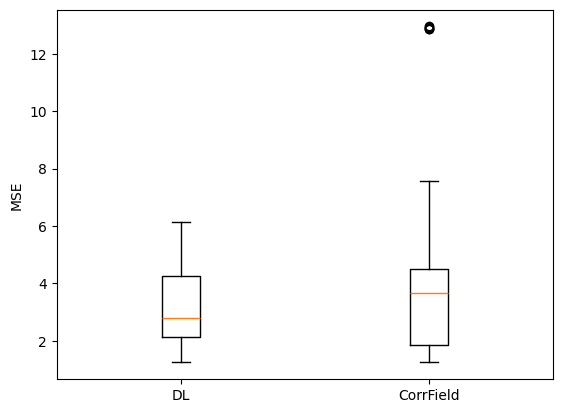

In [90]:
plt.figure()
plt.boxplot([mses_dl, mses_corrfield], tick_labels=["DL", "CorrField"])
plt.ylabel("MSE")
plt.show()


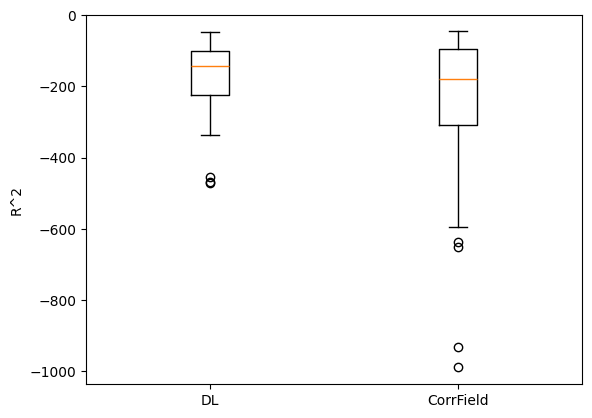

In [89]:
plt.figure()
plt.boxplot([r2_dl, r2_corrfield], tick_labels=["DL", "CorrField"])
plt.ylabel("R^2")
plt.show()

# New non-bullshit approach for generating DDFs

In [25]:
def sample_ddfs(train_loader: torch.utils.data.DataLoader,
                num_samples: int = 4) -> List[torch.Tensor]:
    ddfs = []
    for i, batch in enumerate(train_loader):
        if i == num_samples:
            break

        for key in batch:
            batch[key] = batch[key].cuda()

        ddf, _, _ = corrfield(batch['fixed_image'], batch['fixed_label'], batch['moving_image'], 2.5, 150, 5, 1, 3, 0, 1, 1.4, 0.8, True, [16, 8], [6, 3], [2, 1], [3, 2], ['n', 'n'])
        ddf = ddf.detach().cpu()

        ddf[~batch['moving_label'].squeeze(1).to(torch.bool)] = 0
        ddfs.append({'ddf': ddf, 'fixed_image': batch['fixed_image'], 'moving_image': batch['moving_image'], 'moving_label': batch['moving_label'], 'fixed_label': batch['fixed_label']})

    return ddfs

In [26]:
sampled_ddfs = sample_ddfs(train_loader, num_samples=4)

/gpfs/helios/home/tsiporen/.conda/envs/CTREG/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Compute fixed MIND features ... finished (0.07 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.06 s).

    1275 fixed keypoints extracted (0.06 s).
    Compute forward marginals ... finished (2.07 s).
    Compute symmetric backward marginals ... finished (0.90 s).
    Dense thin plate spline interpolation ... finished (0.19 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).

    2378 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.87 s).
    Compute symmetric backward marginals ... finished (0.76 s).
    Dense thin plate spline interpolation ... finished (0.13 s).

Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
  

In [29]:
scroll_image(sample_batch['moving_image'], sampled_ddfs[1]['ddf'], sample_factor=5, alpha=0.9)

interactive(children=(IntSlider(value=112, continuous_update=False, description='Slice:', max=224), Output()),…

In [30]:
sampled_ddf_masked_tmp = adjust_ddf(sampled_ddfs[1]['ddf'], sample_batch['moving_label'])

In [31]:
scroll_image(sample_batch['moving_image'], sampled_ddf_masked_tmp)

interactive(children=(IntSlider(value=112, continuous_update=False, description='Slice:', max=224), Output()),…

In [43]:
# add smooth gaussian to ddf

def add_noise(ddf: torch.Tensor, noise_std: float = 0.01, smooth_sigma: float = 2.5) -> torch.Tensor:
    noise = torch.randn_like(ddf) * noise_std
    noise = noise.cpu().numpy()

    for i in range(3):
        noise[..., i] = gaussian_filter(noise[..., i], sigma=smooth_sigma)

    noise = torch.from_numpy(noise)
    ddf += noise

    return ddf

In [46]:
noisy_g_ddf = add_noise(sampled_ddfs[1]['ddf'], noise_std=0.1, smooth_sigma=2.5)

In [68]:
scroll_image(sample_batch['moving_image'], adjust_ddf(noisy_g_ddf, sample_batch['moving_label']), sample_factor=5, alpha=0.9)

interactive(children=(IntSlider(value=112, continuous_update=False, description='Slice:', max=224), Output()),…

In [58]:
# create a diferent permutations of the DDFs by using non-zeroing weighted sum of three DDFs

def gen_ddfs(ddfs: List[torch.Tensor], num_generated: int = 50) -> List[torch.Tensor]:
    permuted_ddfs = []
    for i in range(num_generated):
        idxs = np.random.choice(len(ddfs), size=3, replace=False)
        selected_ddfs = [ddfs[idx] for idx in idxs]

        weights = np.random.rand(len(selected_ddfs))
        weights /= np.sum(weights)

        permuted_ddf = sum(w * ddf for w, ddf in zip(weights, selected_ddfs))
        permuted_ddfs.append(permuted_ddf)

    return permuted_ddfs

In [73]:
permuted_ddf = gen_ddfs([sampled_ddfs[3]['ddf'], sampled_ddfs[1]['ddf'], sampled_ddfs[2]['ddf']], num_generated=2)

In [74]:
scroll_image(sample_batch['moving_image'], adjust_ddf(permuted_ddf[1], sample_batch['moving_label']), sample_factor=5, alpha=0.9)

interactive(children=(IntSlider(value=112, continuous_update=False, description='Slice:', max=224), Output()),…